# Credit card

In [92]:
#Import library
require(dplyr)
require(ggplot2)
require(caTools)
require(ROSE)
require(smotefamily)
require(rpart)
require(rpart.plot)
require(caret)

## Tổng quan về dữ liệu

<p align="justify">Tập dữ liệu <b>Fraud Credit Card</b> biểu diễn <i>284 807</i> giao dịch trong 2 ngày ở Châu Âu vào tháng 9 năm 2013. Trong đó, theo điều tra gồm có <i>492</i> gian lận chiếm <i>0.172%</i> tổng các giao dịch. Gồm có 31 biến trong tập dữ liệu:</p>

- _**Time**_ : Thời gian giao dịch diễn ra tính từ giao dịch đầu tiên (seconds)
- <div>\(V_i\) (Với i = 1,2..., 28): Là các thông số sau khi phân tích PCA và ẩn đi thông tin</div>
- _**Amount**_ : Giá trị giao dịch
- _**Class**_ : Gồm có hai giá trị (*0 - Giao dịch bình thường / 1 - Giao dịch gian lận*)

Tập dữ liệu download từ <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud/version/3"><b>Kaggle</b></a>.</p>

In [41]:
credit_dat <- read.csv('creditcard.csv')
head(credit_dat)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,...,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
2,0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,...,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
3,1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,...,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
4,1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,...,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
5,2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,...,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
6,2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,...,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


In [42]:
credit_dat$Class = as.factor(credit_dat$Class)
credit_card = credit_dat

0      1 
284315    492

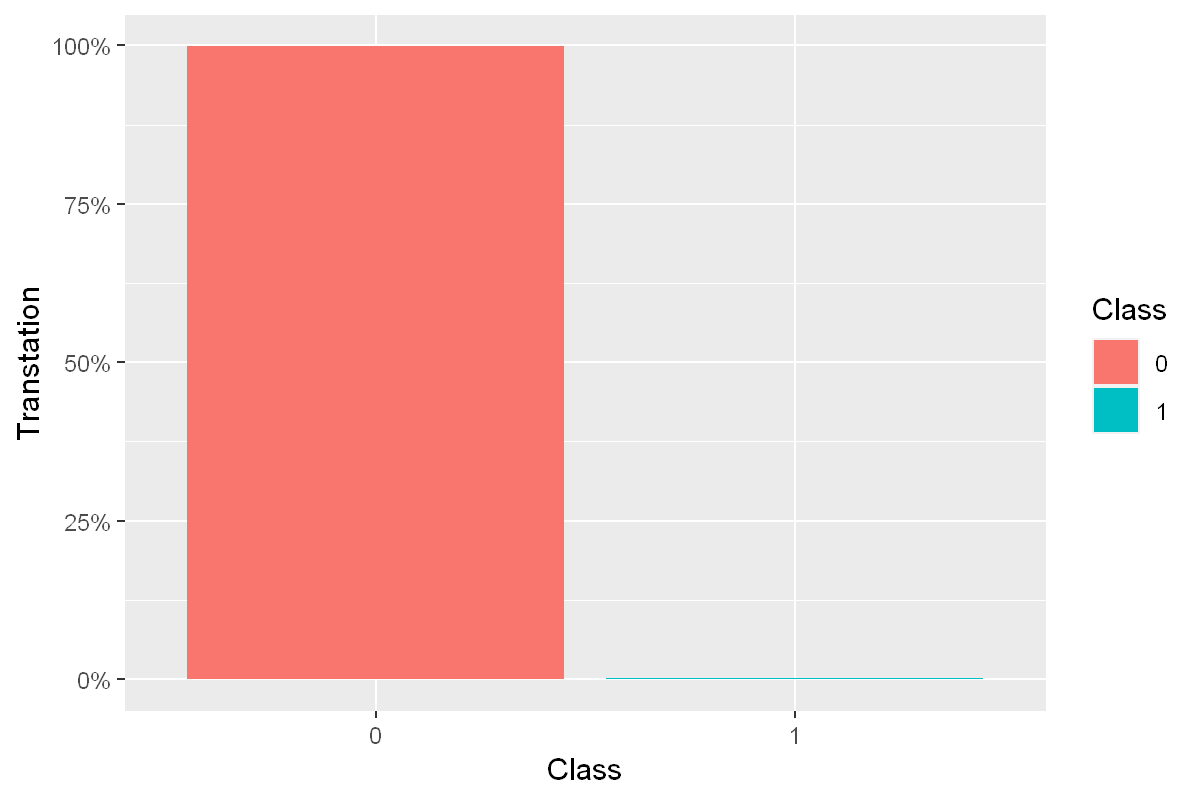

In [43]:
require(ggplot2)
p = ggplot(credit_dat,aes(Class))
summary(credit_dat$Class)
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 200)
p + geom_bar(aes(y = (..count..)/sum(..count..),fill = Class)) +
scale_y_continuous(labels=scales::percent) +
ylab("Transtation") 
# scale_color_manual(values=c('dodgerblue2','red'))

In [44]:
# No model
predictions = rep.int(0,nrow(credit_dat))
predictions = factor(predictions,levels=c(0,1))

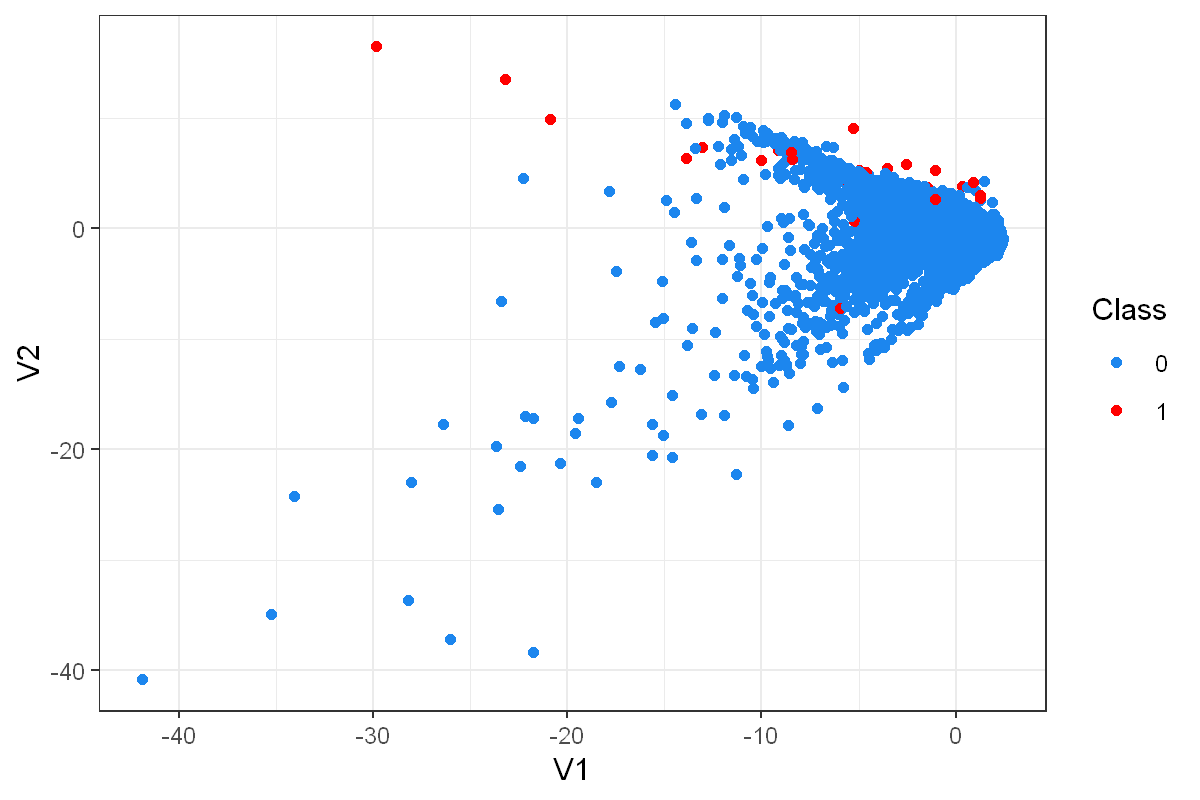

In [45]:
require(dplyr)
set.seed(1)
credit_dat = credit_card %>% sample_frac(0.1)
ggplot(credit_dat, aes(x=V1,y=V2,col=Class)) +
    geom_point() +
    theme_bw() +
    scale_color_manual(values=c('dodgerblue2','red'))

### Tách biệt dữ liệu ra thành 2 tập Train và Test

In [46]:
require(caTools)
set.seed(1)
dat_smpl = sample.split(credit_dat$Class,SplitRat=0.8)
train_dat = subset(credit_dat,dat_smpl == T)
test_dat = subset(credit_dat,dat_smpl == F)
train_dim = dim(train_dat)
test_dim = dim(test_dat)
print(paste(c("Train Dataset: Records = ","Variables = "),train_dim))
print(paste(c("Test Dataset : Records =  ","Variables = "),test_dim))

[1] "Train Dataset: Records =  22785" "Variables =  31"                
[1] "Test Dataset : Records =   5696" "Variables =  31"                


In [47]:
tmp = table(train_dat$Class)
n_total = tmp[1]
n_total
summary(dat_smpl)

0 
22750

   Mode   FALSE    TRUE 
logical    5696   22785 

### Lấy mẫu ROS - Random Over Sampling

In [48]:
require(ROSE)
n_legal = 22750
frac_legal = 0.5
n_total = n_legal/frac_legal
ovrsmpl_res = ovun.sample(
                        Class ~ .
                        , data = train_dat
                        , method = "over"
                        , N = n_total
                        , seed = 100
)


    0     1 
22750 22750 

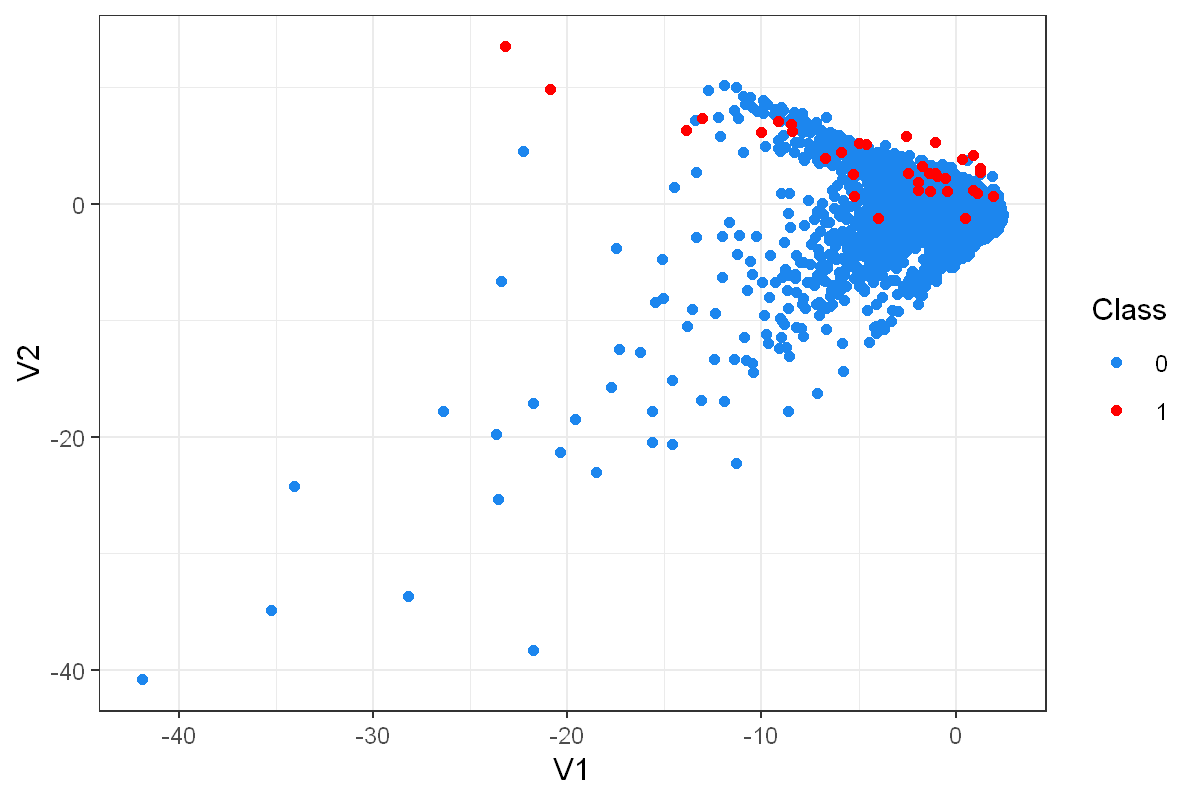

In [49]:
ovrsmpl = ovrsmpl_res$data
table(ovrsmpl$Class)
ggplot(ovrsmpl, aes(x=V1,y=V2,col=Class)) +
    geom_point() +
    theme_bw() +
    scale_color_manual(values=c('dodgerblue2','red'))

### Lấy mẫu RUS - Random Under Sampling


 0  1 
35 35 

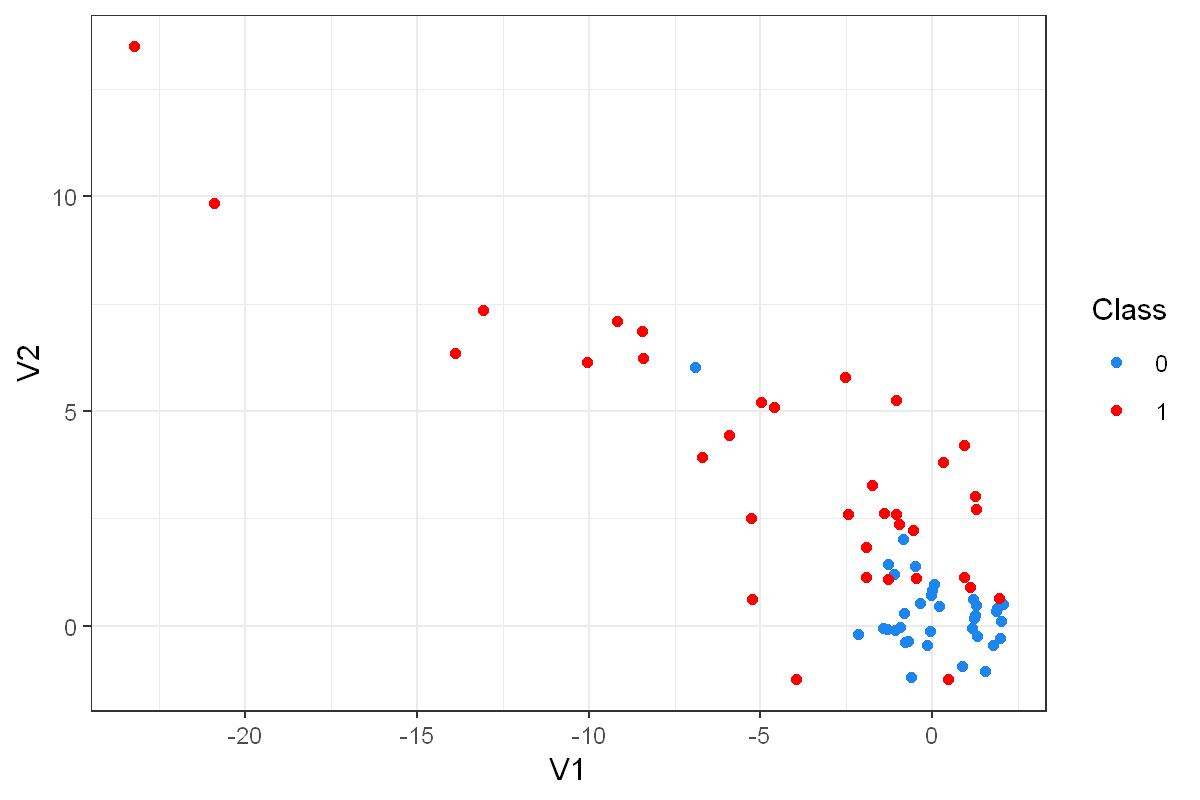

In [51]:
n_fraud = 35
frac_fraud = 0.5
n_total = n_fraud/frac_fraud
undrsmpl_res = ovun.sample(
                        Class ~ .
                        , data = train_dat
                        , method = "under"
                        , N = n_total
                        , seed = 100
)

undrsmpl = undrsmpl_res$data
table(undrsmpl$Class)
ggplot(undrsmpl, aes(x=V1,y=V2,col=Class)) +
    geom_point() +
    theme_bw() +
    scale_color_manual(values=c('dodgerblue2','red'))

### Lấy mẫu kết hợp


    0     1 
11489 11296 

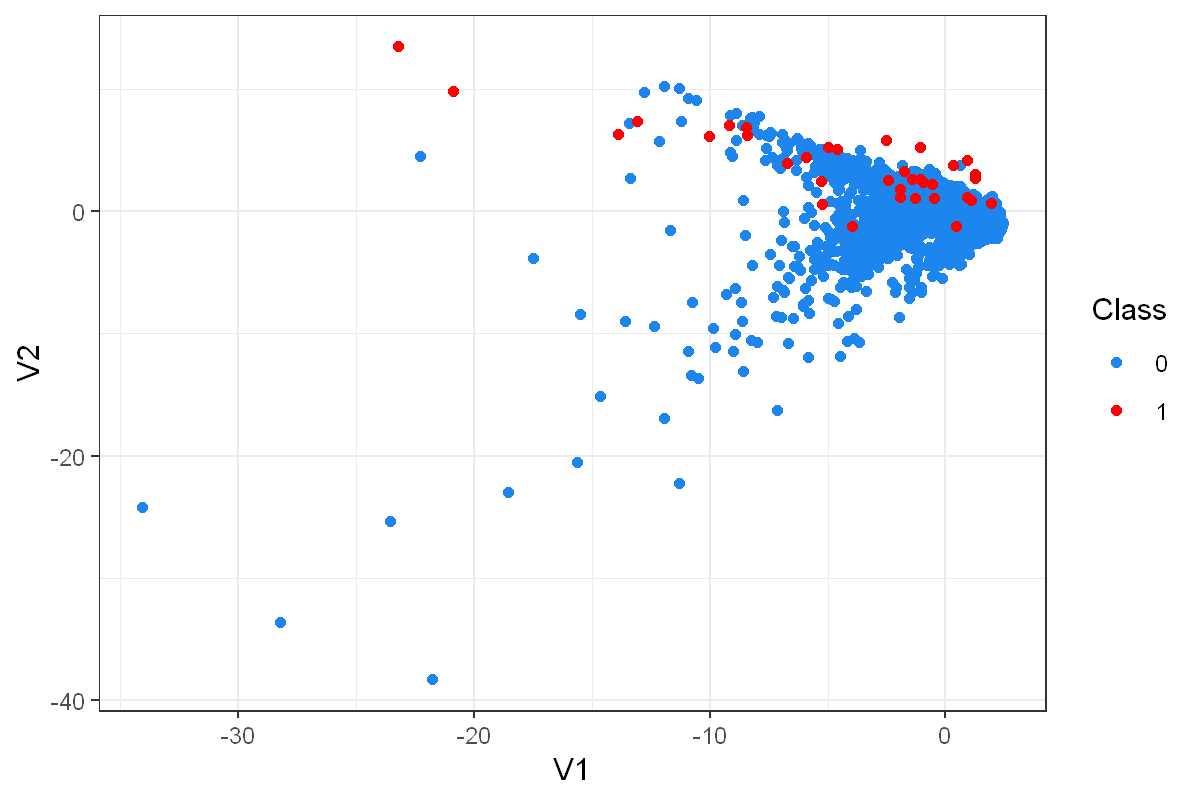

In [52]:
n_smpl = nrow(train_dat)
frac_fraud = 0.5
sampling_res = ovun.sample(
                        Class ~ .
                        , data = train_dat
                        , method = "both"
                        , N = n_smpl
                        , seed = 100
)
sampls = sampling_res$data
table(sampls$Class)
ggplot(sampls, aes(x=V1,y=V2,col=Class)) +
    geom_point() +
    theme_bw() +
    scale_color_manual(values=c('dodgerblue2','red'))

### Lấy mẫu SMOTE

In [61]:
n0 = 22750
n1 = 35
r0 = 0.6
ntimes = ((1-r0)/r0)*(n0/n1)-1


    0     1 
22750 15155 

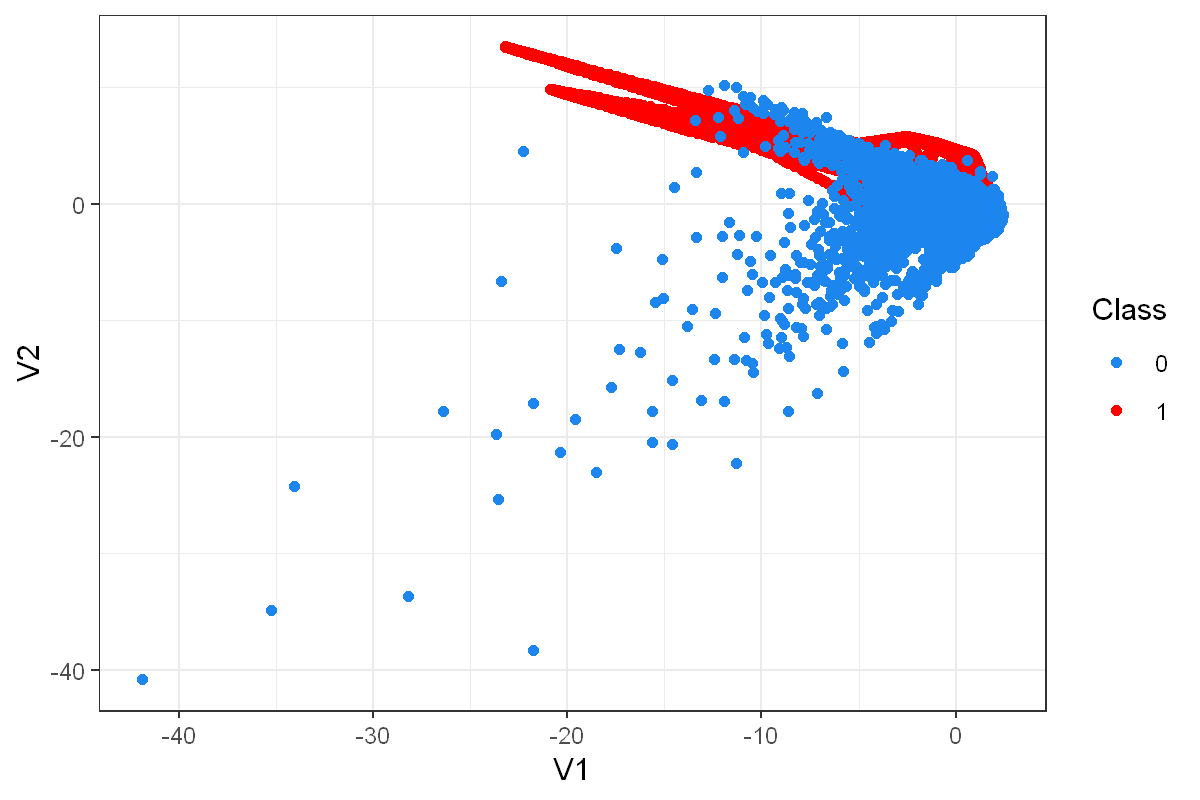

In [64]:
smote_smpl = SMOTE( X = train_dat[,-c(1,31)]
                    , target = train_dat$Class
                    , dup_size = ntimes )
smote = smote_smpl$data
colnames(smote)[30] <- 'Class'
table(smote$Class)
ggplot(smote, aes(x=V1,y=V2,col=Class)) +
    geom_point() +
    theme_bw() +
    scale_color_manual(values=c('dodgerblue2','red'))

## CART MODEL - Classification And Regression Trees

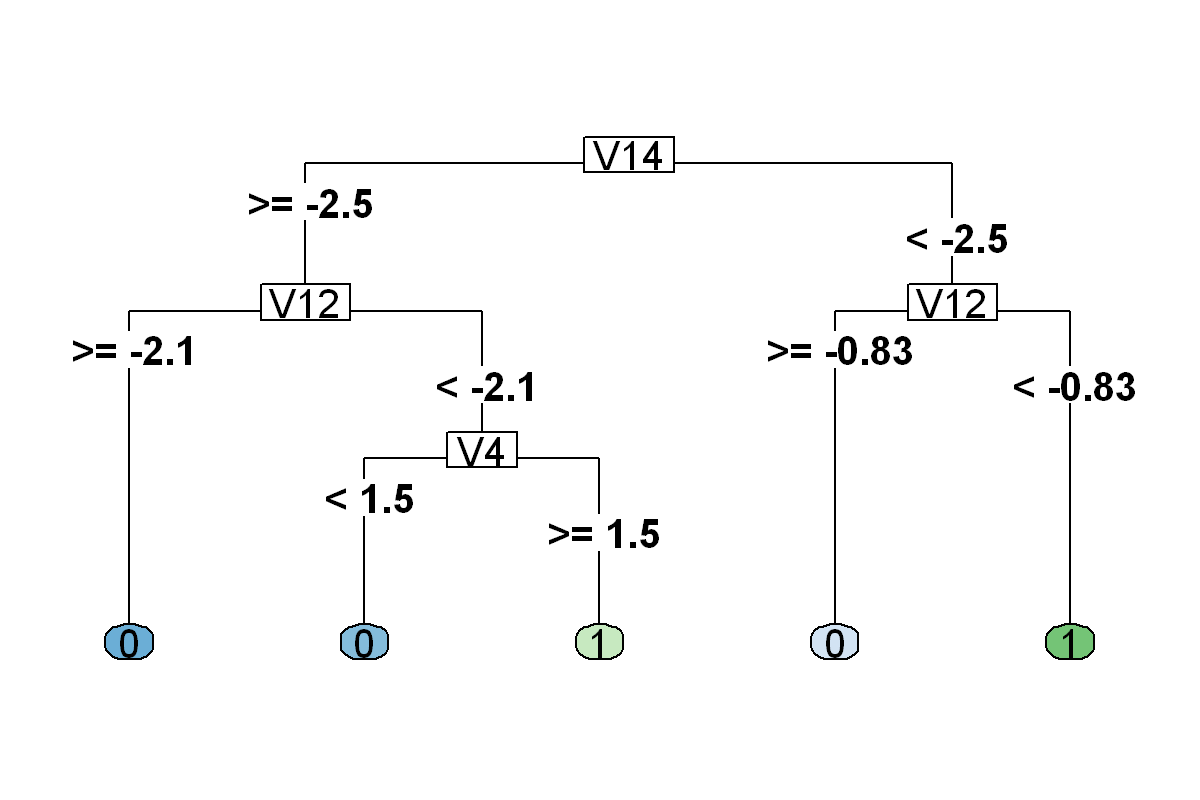

In [67]:
CART_model = rpart(Class ~ ., smote)
rpart.plot(CART_model, extra = 0, type=5, tweak=1.2)

In [89]:
# Predict fraud classe
predicted_val = predict(CART_model, test_dat, type = 'class')
head(predicted_val,24)
summary(predicted_val)

4   6   7  18  21  29  35  41  52  61  70  72  76  77  80  94  99 104 109 111 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
121 135 139 150 
  0   0   0   0 
Levels: 0 1

0    1 
5615   81

In [90]:
summary(test_dat$Class)

0    1 
5687    9

In [91]:
confusionMatrix(predicted_val,test_dat$Class)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5614    1
         1   73    8
                                          
               Accuracy : 0.987           
                 95% CI : (0.9837, 0.9898)
    No Information Rate : 0.9984          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1754          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.98716         
            Specificity : 0.88889         
         Pos Pred Value : 0.99982         
         Neg Pred Value : 0.09877         
             Prevalence : 0.99842         
         Detection Rate : 0.98560         
   Detection Prevalence : 0.98578         
      Balanced Accuracy : 0.93803         
                                          
       'Positive' Class : 0               
                        

In [ ]:
### No SMOTE

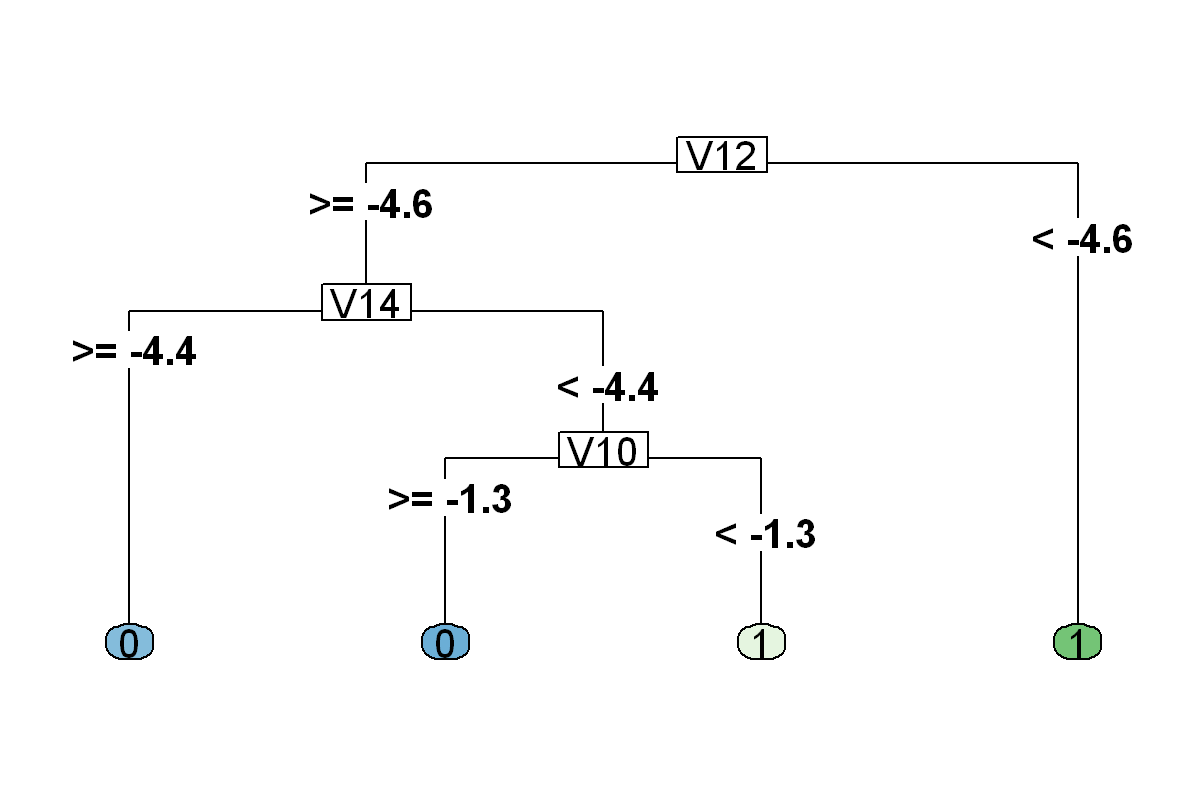

In [93]:
CART_model = rpart(Class ~ . , train_dat[-1])
rpart.plot(CART_model, extra= 0, type = 5, tweak = 1.2)

# Predict fraud classes
predicted_val = predict(CART_model, test_dat[,-1], type= 'class')

In [94]:
predicted_val

4     6     7    18    21    29    35    41    52    61    70    72    76 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
   77    80    94    99   104   109   111   121   135   139   150   162   165 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  172   173   176   180   183   185   189   194   198   211   214   215   218 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  219   225   230   243   251   253   261   284   294   301   307   309   314 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  320   325   326   327   328   332   335   341   342   356   358   360   364 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  367   374   379   385   389   391   394   404   405   406   411   412   421 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  429   430   431   432   441   449   452   459   467   473   478   484   485 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  490   493   500   507   509   512   522   527   528   530   531   543   548 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  552   555   560   561   566   571   576   580   583   590   596   602   603 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  606   607   610   612   622   631   632   635   642   644   649   651   653 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  661   668   674   691   694   700   702   703   710   724   727   739   749 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  753   760   764   770   773   775   781   782   786   794   800   802   804 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  809   815   818   819   825   826   833   834   839   840   842   852   855 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  873   874   881   883   884   885   888   902   921   923   924   926   927 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  933   938   940   943   950   951   955   958   969   970   972   975   984 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
  990  1005  1010  1012  1015  1017  1018  1023  1025  1035  1040  1051  1055 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 1056  1063  1064  1067  1070  1076  1087  1090  1101  1110  1125  1127  1132 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 1140  1144  1150  1152  1155  1156  1166  1168  1172  1186  1193  1197  1198 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 1204  1207  1209  1217  1218  1225  1230  1238  1247  1248  1249  1256  1261 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 1270  1276  1280  1282  1294  1295  1307  1308  1326  1333  1335  1341  1342 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 1346  1363  1364  1365  1376  1379  1381  1382  1385  1392  1398  1402  1407 
    0     0     0     0     1     0     0     0     0     0     0     0     0 
 1410  1421  1423  1425  1427  1434  1436  1439  1442  1443  1449  1459  1467 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 1472  1476  1477  1481  1489  1494  1497  1501  1502  1503  1506  1517  1518 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 1519  1526  1528  1530  1532  1534  1535  1539  1548  1549  1551  1557  1560 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 1562  1563  1567  1570  1572  1573  1578  1580  1584  1586  1587  1588  1596 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 1603  1608  1609  1619  1620  1624  1630  1632  1635 

In [96]:
confusionMatrix(predicted_val,test_dat$Class)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5682    0
         1    5    9
                                         
               Accuracy : 0.9991         
                 95% CI : (0.998, 0.9997)
    No Information Rate : 0.9984         
    P-Value [Acc > NIR] : 0.11550        
                                         
                  Kappa : 0.7822         
                                         
 Mcnemar's Test P-Value : 0.07364        
                                         
            Sensitivity : 0.9991         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.6429         
             Prevalence : 0.9984         
         Detection Rate : 0.9975         
   Detection Prevalence : 0.9975         
      Balanced Accuracy : 0.9996         
                                         
       'Positive' Class : 0              
                                         

### Testing với tập dữ liệu ban đầu

In [97]:
# Predict fraud classe
predicted_val = predict(CART_model, credit_card, type = 'class')
head(predicted_val,24)
summary(predicted_val)

1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
Levels: 0 1

0      1 
284312    495

In [100]:
confusionMatrix(predicted_val,credit_card$Class)

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 284205    107
         1    110    385
                                          
               Accuracy : 0.9992          
                 95% CI : (0.9991, 0.9993)
    No Information Rate : 0.9983          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7798          
                                          
 Mcnemar's Test P-Value : 0.892           
                                          
            Sensitivity : 0.9996          
            Specificity : 0.7825          
         Pos Pred Value : 0.9996          
         Neg Pred Value : 0.7778          
             Prevalence : 0.9983          
         Detection Rate : 0.9979          
   Detection Prevalence : 0.9983          
      Balanced Accuracy : 0.8911          
                                          
       'Positive' Class : 0               
            